In [ ]:
# --- GPU check
!nvidia-smi

# --- Core libs
!pip -q install "torch>=2.5.1" "torchvision>=0.20.1" --index-url https://download.pytorch.org/whl/cu121
!pip -q install sam2 transformers timm opencv-python matplotlib pillow scipy

# --- Clone SAM 2 repo for configs
!git clone -q https://github.com/facebookresearch/sam2
!pip -q install -e sam2

# --- Download a SAM 2.1 checkpoint
!mkdir -p sam2_checkpoints
!wget -q -O sam2_checkpoints/sam2.1_hiera_small.pt https://dl.fbaipublicfiles.com/segment_anything_2/checkpoints/sam2.1_hiera_small.pt


Sat Oct  4 06:36:52 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.15              Driver Version: 550.54.15      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  NVIDIA A100-SXM4-40GB          Off |   00000000:00:04.0 Off |                    0 |
| N/A   32C    P0             54W /  400W |    1037MiB /  40960MiB |      0%      Default |
|                                         |                        |             Disabled |
+-----------------------------------------+-----

In [ ]:
import os, io, math, urllib.request
import numpy as np
import cv2
import matplotlib.pyplot as plt
from PIL import Image
import torch

# CLIPSeg (Hugging Face Transformers)
from transformers import CLIPSegProcessor, CLIPSegForImageSegmentation

# SAM 2 (image predictor)
from sam2.build_sam import build_sam2_hf
from sam2.sam2_image_predictor import SAM2ImagePredictor

def imread_any(path_or_url):
    if str(path_or_url).startswith(("http://","https://")):
        with urllib.request.urlopen(path_or_url) as r:
            data = r.read()
        return Image.open(io.BytesIO(data)).convert("RGB")
    return Image.open(path_or_url).convert("RGB")

def show_overlay(img_rgb, mask, alpha=0.55):
    img = np.asarray(img_rgb).copy()
    if mask.shape[:2] != img.shape[:2]:
        mask = cv2.resize(mask.astype(np.float32), (img.shape[1], img.shape[0]), interpolation=cv2.INTER_LINEAR)
    mask = mask.astype(np.float32)
    mask = (mask - mask.min()) / (mask.max() - mask.min() + 1e-8)
    overlay = (mask * 255).astype(np.uint8)
    overlay = cv2.applyColorMap(overlay, cv2.COLORMAP_JET)
    overlay = cv2.cvtColor(overlay, cv2.COLOR_BGR2RGB)
    out = (alpha*overlay + (1-alpha)*img).astype(np.uint8)
    plt.figure(figsize=(8,8)); plt.axis("off"); plt.imshow(out); plt.show()

# get all connected components
def connected_components_masks(mask_bin, min_area=300):
    """
    Return a list of boolean masks for all connected components
    larger than min_area pixels.
    """
    num, lbl = cv2.connectedComponents(mask_bin.astype(np.uint8))
    masks = []
    for i in range(1, num):
        comp = (lbl == i)
        if comp.sum() >= min_area:
            masks.append(comp)
    return masks

def bbox_from_mask(mask_bool):
    ys, xs = np.where(mask_bool)
    if len(xs) == 0:
        return None
    x0, y0, x1, y1 = xs.min(), ys.min(), xs.max(), ys.max()
    return np.array([x0, y0, x1, y1], dtype=np.int32)

def sample_points(mask_bool, n_pos=8, n_neg=8, border=5):
    h, w = mask_bool.shape
    pos_idx = np.argwhere(mask_bool)
    neg = mask_bool.copy()
    # dilate positive to avoid negatives too close
    k = np.ones((border*2+1, border*2+1), np.uint8)
    neg = cv2.dilate(mask_bool.astype(np.uint8), k, iterations=1).astype(bool)
    neg_idx = np.argwhere(~neg)

    def pick(arr, k):
        if len(arr) == 0:
            return np.zeros((0, 2), int)
        if len(arr) < k:
            k = len(arr)
        sel = arr[np.random.choice(len(arr), k, replace=False)]
        return sel[:, [1, 0]]  # to (x, y)

    pts_pos = pick(pos_idx, n_pos)
    pts_neg = pick(neg_idx, n_neg)
    labels = np.concatenate([np.ones(len(pts_pos)), np.zeros(len(pts_neg))]).astype(np.int32)
    pts = np.vstack([pts_pos, pts_neg]) if len(pts_neg) else pts_pos
    return pts, labels


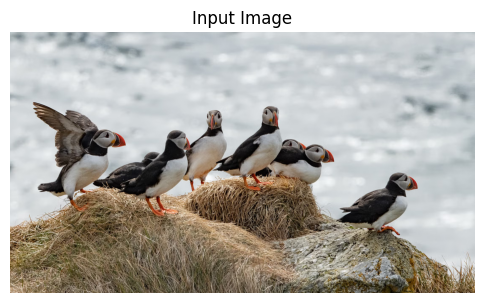

In [ ]:
# You can change this to a local path or any image URL
IMAGE_PATH = "SAM.jpg"
TEXT_PROMPT = "black and white birds"  # <-- edit your text prompt

image_pil = imread_any(IMAGE_PATH)
plt.figure(figsize=(6,6)); plt.axis("off"); plt.imshow(image_pil); plt.title("Input Image"); plt.show()


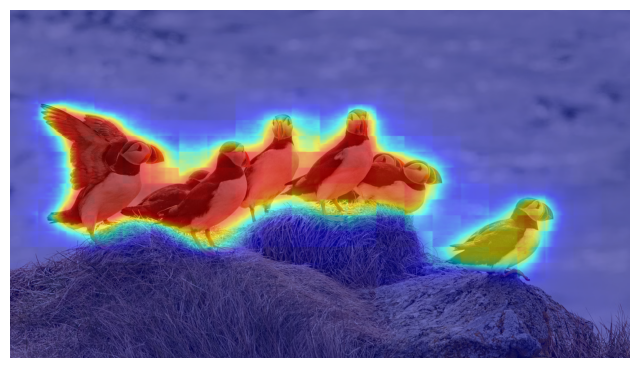

In [ ]:
import torch.nn.functional as F

device = "cuda" if torch.cuda.is_available() else "cpu"

# Use CLIPSeg without the deprecated/ignored 'padding' arg
processor = CLIPSegProcessor.from_pretrained("CIDAS/clipseg-rd64-refined")
model = CLIPSegForImageSegmentation.from_pretrained("CIDAS/clipseg-rd64-refined").to(device)

# Prepare inputs
inputs = processor(
    text=[TEXT_PROMPT],
    images=image_pil,
    return_tensors="pt"
).to(device)

with torch.inference_mode():
    outputs = model(**inputs)   # logits: shape can vary by version

logits = outputs.logits  # common cases: (1, 1, H', W') or (1, H', W')
H, W = image_pil.height, image_pil.width

# Normalize dimension to (B,1,H',W'), then bilinear-resize to image size
if logits.ndim == 3:                 # (B, H', W')
    logits = logits[:, None, ...]    # -> (B,1,H',W')
elif logits.ndim != 4:
    raise ValueError(f"Unexpected CLIPSeg logits shape: {logits.shape}")

logits_up = F.interpolate(logits, size=(H, W), mode="bilinear", align_corners=False)
clipseg_mask = torch.sigmoid(logits_up)[0, 0].detach().cpu().numpy()  # (H, W)

# Visualize safely: mask and image now match sizes
show_overlay(image_pil, clipseg_mask, alpha=0.55)


#components kept: 2


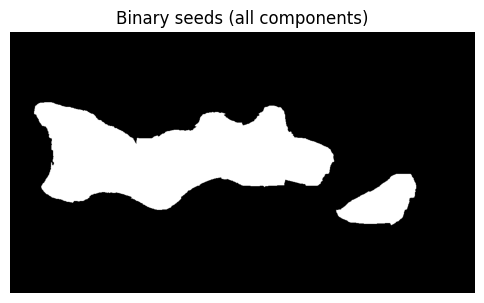

Per-component seeds:
  comp 0: box=[ 57 168 766 421], #pts=16
  comp 1: box=[771 337 960 457], #pts=16


In [ ]:
# --- Threshold with Otsu on normalized map (no largest-CC filtering) ---
m = clipseg_mask
m_norm = (m - m.min()) / (m.max() - m.min() + 1e-8)
m_uint = (m_norm * 255).astype(np.uint8)

# Otsu threshold
thr, _ = cv2.threshold(m_uint, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
mask_bin = (m_uint >= thr).astype(np.uint8)

# Fallback if Otsu yields empty (prompt mismatch)
if mask_bin.sum() == 0:
    cutoff = np.quantile(m_norm, 0.97)  # top 3%
    mask_bin = (m_norm >= cutoff).astype(np.uint8)

# --- Keep ALL connected components above a small area ---
def connected_components_masks(mask_bin, min_area=300):
    num, lbl = cv2.connectedComponents(mask_bin.astype(np.uint8))
    masks = []
    for i in range(1, num):
        comp = (lbl == i)
        if comp.sum() >= min_area:
            masks.append(comp)
    return masks

masks_cc = connected_components_masks(mask_bin, min_area=300)  # tune if needed
print(f"#components kept: {len(masks_cc)}")

# Quick viz: union of all components
if masks_cc:
    union_mask = np.logical_or.reduce(masks_cc).astype(np.uint8)
else:
    union_mask = np.zeros_like(mask_bin, dtype=np.uint8)

plt.figure(figsize=(6,6))
plt.imshow(union_mask, cmap="gray")
plt.title("Binary seeds (all components)")
plt.axis("off")
plt.show()

# --- Derive box + points for EACH component (feed these to SAM 2) ---
boxes_pts_labels = []
for comp in masks_cc:
    box_xyxy = bbox_from_mask(comp)
    pts, labels = sample_points(comp, n_pos=8, n_neg=8)
    boxes_pts_labels.append((box_xyxy, pts, labels))

print("Per-component seeds:")
for i, (box_xyxy, pts, labels) in enumerate(boxes_pts_labels):
    print(f"  comp {i}: box={box_xyxy}, #pts={len(pts)}")


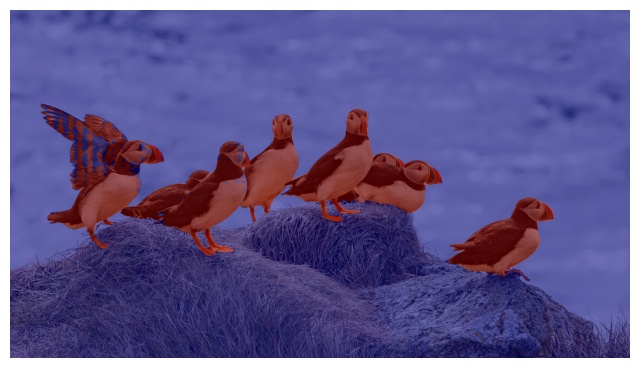

In [ ]:
# --- Multi-instance SAM prediction ---
all_masks = []

for i, (box_xyxy, pts, labels) in enumerate(boxes_pts_labels):
    inputs = {}
    if box_xyxy is not None:
        inputs["box"] = box_xyxy[None, :].astype(np.float32)
    if len(pts) > 0:
        inputs["point_coords"] = pts[None, ...].astype(np.float32)
        inputs["point_labels"] = labels[None, ...].astype(np.int32)

    with torch.inference_mode(), torch.autocast("cuda", dtype=torch.bfloat16, enabled=(device=="cuda")):
        masks, scores, _ = predictor.predict(**inputs, multimask_output=True)

    best = int(np.argmax(scores))
    all_masks.append(masks[best])

# Combine all instance masks into one final mask
if all_masks:
    combined_mask = np.logical_or.reduce(all_masks).astype(np.uint8)
else:
    combined_mask = np.zeros(img_np.shape[:2], dtype=np.uint8)

# --- Visualize final result ---
show_overlay(image_pil, combined_mask.astype(np.float32), alpha=0.55)


In [ ]:
# --- Install & import dependencies ---
!pip -q install sam2 transformers timm opencv-python matplotlib pillow scipy

import os, io, urllib.request
import numpy as np
import cv2
import matplotlib.pyplot as plt
from PIL import Image
import torch
import torch.nn.functional as F

from transformers import CLIPSegProcessor, CLIPSegForImageSegmentation
from sam2.build_sam import build_sam2_hf
from sam2.sam2_image_predictor import SAM2ImagePredictor

# --- Utility functions ---
def read_video_cv2(path, max_seconds=None, stride=1):
    cap = cv2.VideoCapture(path)
    assert cap.isOpened(), f"Cannot open video: {path}"
    fps = cap.get(cv2.CAP_PROP_FPS) or 25
    frames = []
    max_frames = int(fps * max_seconds) if max_seconds else None
    i = 0
    while True:
        ok, f = cap.read()
        if not ok: break
        if i % stride == 0:
            frames.append(cv2.cvtColor(f, cv2.COLOR_BGR2RGB))
        i += 1
        if max_frames and len(frames) >= max_frames:
            break
    cap.release()
    return frames, fps

def write_video_cv2(rgb_frames, path, fps=25):
    if len(rgb_frames) == 0: return
    h, w = rgb_frames[0].shape[:2]
    vw = cv2.VideoWriter(path, cv2.VideoWriter_fourcc(*"mp4v"), fps, (w, h))
    for f in rgb_frames:
        vw.write(cv2.cvtColor(f, cv2.COLOR_RGB2BGR))
    vw.release()

def overlay_mask_on_frame(rgb, mask, alpha=0.55):
    img = rgb.astype(np.uint8)
    m = mask.astype(np.float32)
    m = (m - m.min()) / (m.max() - m.min() + 1e-8)
    heat = (m * 255).astype(np.uint8)
    heat = cv2.applyColorMap(heat, cv2.COLORMAP_JET)
    heat = cv2.cvtColor(heat, cv2.COLOR_BGR2RGB)
    return (alpha * heat + (1 - alpha) * img).astype(np.uint8)

def connected_components_masks(mask_bin, min_area=300):
    num, lbl = cv2.connectedComponents(mask_bin.astype(np.uint8))
    return [(lbl == i) for i in range(1, num) if (lbl == i).sum() >= min_area]

def bbox_from_mask(mask_bool):
    ys, xs = np.where(mask_bool)
    if len(xs) == 0: return None
    return np.array([xs.min(), ys.min(), xs.max(), ys.max()], dtype=np.int32)

def sample_points(mask_bool, n_pos=8, n_neg=8, border=5):
    pos_idx = np.argwhere(mask_bool)
    neg = cv2.dilate(mask_bool.astype(np.uint8), np.ones((border*2+1, border*2+1), np.uint8), 1).astype(bool)
    neg_idx = np.argwhere(~neg)
    def pick(arr, k):
        if len(arr) == 0: return np.zeros((0,2), int)
        if len(arr) < k: k = len(arr)
        sel = arr[np.random.choice(len(arr), k, replace=False)]
        return sel[:, [1, 0]]
    pts_pos = pick(pos_idx, n_pos)
    pts_neg = pick(neg_idx, n_neg)
    labels = np.concatenate([np.ones(len(pts_pos)), np.zeros(len(pts_neg))]).astype(np.int32)
    pts = np.vstack([pts_pos, pts_neg]) if len(pts_neg) else pts_pos
    return pts, labels

# --- CLIPSeg helper ---
def clipseg_binary_mask(img_pil, text_prompt, top_pct_fallback=0.97, min_cc_area=300):
    inputs = processor(text=[text_prompt], images=img_pil, return_tensors="pt").to(device)
    with torch.inference_mode():
        outputs = model(**inputs)
    logits = outputs.logits
    if logits.ndim == 3: logits = logits[:, None, ...]
    H, W = img_pil.height, img_pil.width
    logits_up = F.interpolate(logits, size=(H, W), mode="bilinear", align_corners=False)
    prob = torch.sigmoid(logits_up)[0, 0].detach().cpu().numpy()

    p_norm = (prob - prob.min()) / (prob.max() - prob.min() + 1e-8)
    p_u8 = (p_norm * 255).astype(np.uint8)
    thr, _ = cv2.threshold(p_u8, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
    mask_bin = (p_u8 >= thr).astype(np.uint8)
    if mask_bin.sum() == 0:
        cutoff = np.quantile(p_norm, top_pct_fallback)
        mask_bin = (p_norm >= cutoff).astype(np.uint8)

    return p_norm, connected_components_masks(mask_bin, min_area=min_cc_area)

# --- Optical flow mask warp ---
def warp_mask_with_flow(prev_mask, prev_rgb, curr_rgb):
    prev_gray = cv2.cvtColor(prev_rgb, cv2.COLOR_RGB2GRAY)
    curr_gray = cv2.cvtColor(curr_rgb, cv2.COLOR_RGB2GRAY)
    flow = cv2.calcOpticalFlowFarneback(prev_gray, curr_gray, None, 0.5, 3, 15, 3, 5, 1.2, 0)
    h, w = prev_gray.shape
    grid_x, grid_y = np.meshgrid(np.arange(w), np.arange(h))
    map_x = (grid_x + flow[..., 0]).astype(np.float32)
    map_y = (grid_y + flow[..., 1]).astype(np.float32)
    warped = cv2.remap(prev_mask.astype(np.uint8), map_x, map_y, cv2.INTER_NEAREST)
    return (warped > 0).astype(np.uint8)

# --- SAM2 refinement ---
def refine_with_sam2(rgb, seed_mask):
    box = bbox_from_mask(seed_mask.astype(bool))
    pts, labels = sample_points(seed_mask.astype(bool))
    inp = {}
    if box is not None:
        inp["box"] = box[None, :].astype(np.float32)
    if len(pts) > 0:
        inp["point_coords"] = pts[None, ...].astype(np.float32)
        inp["point_labels"] = labels[None, ...].astype(np.int32)
    predictor.set_image(rgb.astype(np.uint8))
    with torch.inference_mode(), torch.autocast("cuda", dtype=torch.bfloat16, enabled=(device == "cuda")):
        masks, scores, _ = predictor.predict(**inp, multimask_output=True)
    return masks[int(np.argmax(scores))].astype(np.uint8)

# --- Load models ---
device = "cuda" if torch.cuda.is_available() else "cpu"
processor = CLIPSegProcessor.from_pretrained("CIDAS/clipseg-rd64-refined")
model = CLIPSegForImageSegmentation.from_pretrained("CIDAS/clipseg-rd64-refined").to(device)
sam2_model = build_sam2_hf("facebook/sam2.1-hiera-small", device=device)
predictor = SAM2ImagePredictor(sam2_model)

# --- Main video segmentation pipeline ---
VIDEO_PATH = "/content/istockphoto-480841066-640_adpp_is.mp4"   # TODO: upload your clip
TEXT_PROMPT = "Bird"                     # <-- change as needed
frames, fps = read_video_cv2(VIDEO_PATH, max_seconds=30)
print(f"Loaded {len(frames)} frames at {fps} fps")

# seeds from first frame
first_pil = Image.fromarray(frames[0])
_, comps = clipseg_binary_mask(first_pil, TEXT_PROMPT, min_cc_area=300)
assert len(comps) > 0, "No foreground found — try a more specific prompt."

init_mask = np.logical_or.reduce(comps).astype(np.uint8)
m_prev = refine_with_sam2(frames[0], init_mask)
overlaid_frames = [overlay_mask_on_frame(frames[0], m_prev)]

# propagate forward
for t in range(1, len(frames)):
    warped = warp_mask_with_flow(m_prev, frames[t - 1], frames[t])
    if warped.sum() < 50:  # fallback if mask collapses
        H, W = warped.shape
        warped = np.ones((H, W), np.uint8)
    m_curr = refine_with_sam2(frames[t], warped)
    overlaid_frames.append(overlay_mask_on_frame(frames[t], m_curr))
    m_prev = m_curr

# save result
OUT_PATH = "/content/text_segmentation_output.mp4"
write_video_cv2(overlaid_frames, OUT_PATH, fps=fps)
print(f"Segmented video saved at: {OUT_PATH}")


Loaded 299 frames at 29.97002997002997 fps
✅ Segmented video saved at: /content/text_segmentation_output.mp4
